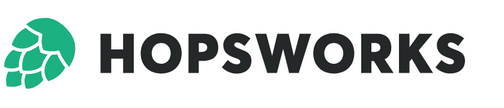

# Part 03: Model training & UI Exploration
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/logicalclocks/hopsworks-tutorials/blob/master/fraud_batch/3_model_training.ipynb)

**Note**: you may get an error when installing hopsworks on Colab, and it is safe to ignore it.

In this last notebook, we will train a model on the dataset we created in the previous tutorial. We will train our model using standard Python and Scikit-learn, although it could just as well be trained with other machine learning frameworks such as PySpark, TensorFlow, and PyTorch. We will also show some of the exploration that can be done in Hopsworks, notably the search functions and the lineage.

## 🗒️ This notebook is divided in 3 main sections:
1. **Loading the training data**
2. **Train the model**
3. **Explore feature groups and views** via the UI.

![tutorial-flow](../images/03_model.png)

In [ ]:
!pip install -U hopsworks --quiet

In [ ]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

## <span style="color:#ff5f27;"> ✨ Load Training Data </span>

First, we'll need to fetch the training dataset that we created in the previous notebook. We will use January - February data training and testing.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Load data.
feature_view = fs.get_feature_view(
    name = "transactions_view_fraud_batch_fv",
    version = 1
)

X_train, y_train, X_val, y_val, X_test, y_test = feature_view.get_train_validation_test_split(1)

We will train a model to predict `fraud_label` given the rest of the features.

Let's check the distribution of our target label.

In [ ]:
y_train.value_counts(normalize=True)

Notice that the distribution is extremely skewed, which is natural considering that fraudulent transactions make up a tiny part of all transactions. Thus we should somehow address the class imbalance. There are many approaches for this, such as weighting the loss function, over- or undersampling, creating synthetic data, or modifying the decision threshold. In this example, we'll use the simplest method which is to just supply a class weight parameter to our learning algorithm. The class weight will affect how much importance is attached to each class, which in our case means that higher importance will be placed on positive (fraudulent) samples.

---
## <span style="color:#ff5f27;"> ⚜️ Weights and Biases </span>

**Weight & Biases** is a free Python library that allows you to track, compare, and visualize ML experiments -> build better models faster. 

In our case we will use **W&B** to track Data Lineage using **Artifacts**, find the best hyperparameters using **Sweep** and visualize model performance.

To begin with, let's install `wandb` library.

In [ ]:
!pip install wandb --quiet

Sign up for a free account by going to the [sign up page](https://wandb.ai/home).

After that you should login.

In [ ]:
import wandb

wandb.login()

## <span style="color:#ff5f27;"> 📝 W&B Artifacts </span>

Use W&B Artifacts for dataset versioning, model versioning, and tracking dependencies and results across machine learning pipelines. Think of an artifact as a versioned folder of data. You can store entire datasets directly in artifacts, or use artifact references to point to data in other systems like S3, GCP, or your own system. 

Also you can visualize Data Lineage for better understanding of project pipeline.

In [ ]:
PROJECT_NAME = 'fraud_batch'

In [ ]:
# create a run in W&B
run = wandb.init(
    project=PROJECT_NAME,
    job_type="upload_feature_view",
    name='metadata'
)

# create an artifact for all the raw data
raw_data_at = wandb.Artifact(
    "transactions_view_fraud_batch_fv_version1", 
    type="feature_view",
    metadata = {key:value.__repr__() for key,value in feature_view.to_dict().items()}
)

# save artifact to W&B
run.log_artifact(raw_data_at)

In [ ]:
run = wandb.init(
    project=PROJECT_NAME,
    name="train_validation_test_split",
    job_type='split'
)

data_at = run.use_artifact("transactions_view_fraud_batch_fv_version1:latest")
data_dir = data_at.download()

artifacts = {}

for split in ['train','validation','test']:
    artifacts[split] = wandb.Artifact(f'{split}_split', type="split")  
    
for split, artifact in artifacts.items():
    run.log_artifact(artifact)

To check Data Lineage follow next steps:

1. Go to the [W&B main page](https://wandb.ai/home).

2. Select the "Artifacts" icon in the left sidebar.

3. Inspect the `transactions_view_fraud_batch_fv_version1` type artifact.

4. Go to the **Lineage** and then press **Explode**.

So for now Data Lineage should look like this:

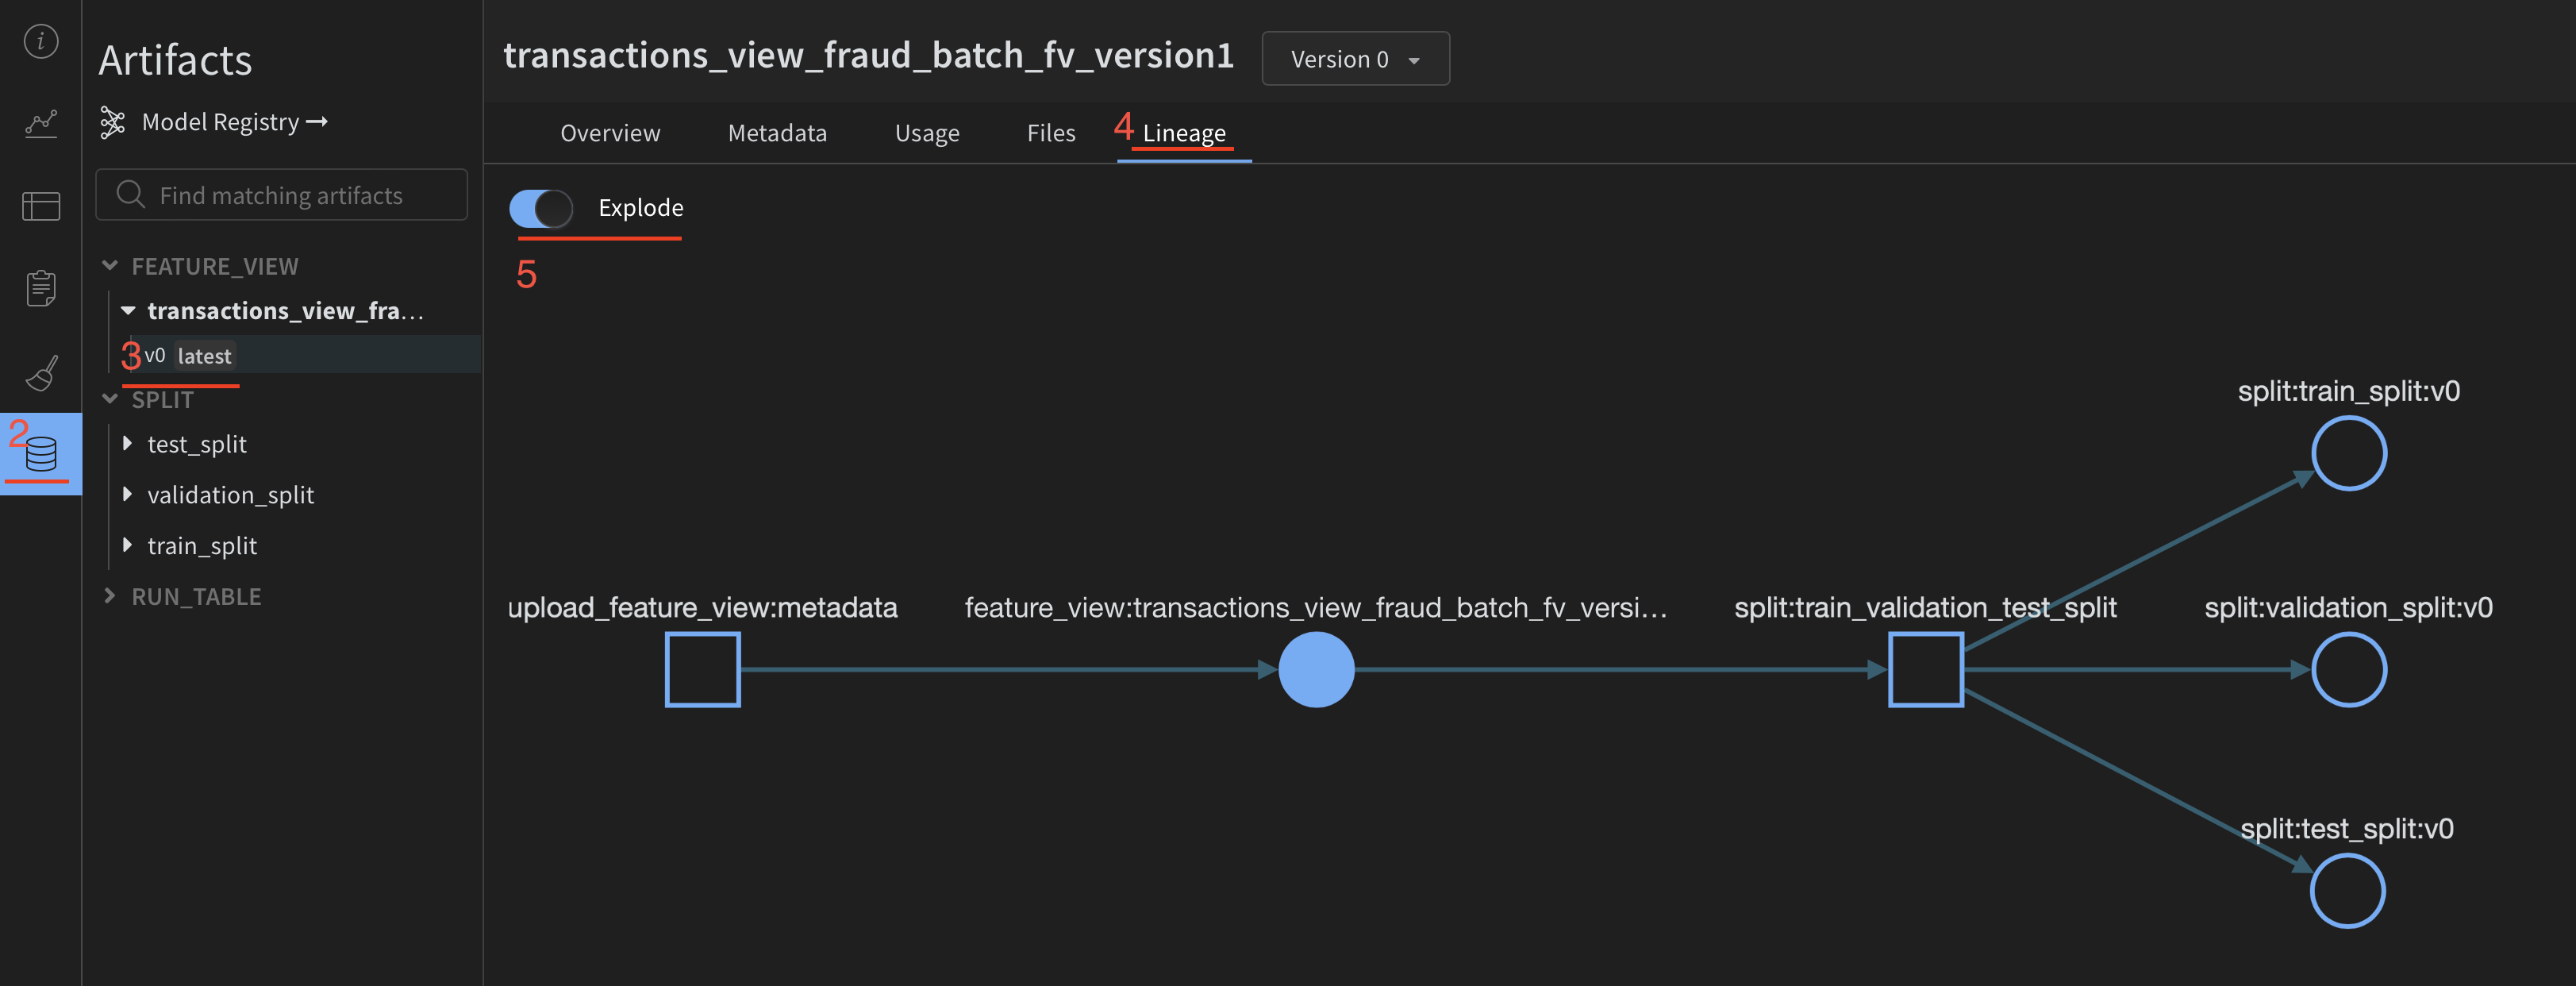

---
## <span style="color:#ff5f27;"> 👩🏻‍🔬 Define Model Training Function</span>

It is important to define a function which will be used by the Sweep agent.

In this function we:

- Set default hyperparameters for the model.

- Initialize a new W&B Run using `wandb.init`.

- Register all hyperparameters through `wandb.config`.

- Create a RandomForestClassifier with a set of hyperparameters.

- Fit a RandomForestClassifier.

- Predict and evaluate.

- Log all metrics using `wandb.log`.

- Plot beautiful plots using `wandb.sklearn.plot_classifier`.

In [ ]:
def train_model(X_train=X_train, y_train=y_train,X_test=X_test, y_test=y_test):

    config_defaults = {
        'n_estimators': 100, 
        'criterion': 'gini',
        'min_samples_split': 10
    }
    features = X_train.columns

    wandb.init(config=config_defaults)
    config = wandb.config

    model = RandomForestClassifier(
        n_estimators=config.n_estimators, 
        criterion=config.criterion,
        min_samples_split=config.min_samples_split,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
        class_weight={0: 0.1, 1: 0.9}
    )
    model.fit(X_train, y_train)

    y_preds = model.predict(X_test)
    y_probas = model.predict_proba(X_test)
  
    score = f1_score(y_test, y_preds)
    print(f"F1_score: {round(score, 4)}")

    wandb.log({"F1_score": score})
    
    wandb.sklearn.plot_classifier(model, X_train, X_test, y_train, y_test, 
                                y_preds, y_probas, features, model_name='RandomForestClassifier')

---
## <span style="color:#ff5f27;"> 📝 Define Sweep Configurations</span>

The next step is to define configurations for Sweep.

**Weights & Biases Sweeps** are used to automate hyperparameter optimization and explore the space of possible models.

You will initialize Sweep in form of a dictionary.

You should include next steps:

- `method`: specify your search strategy (**Bayesian**, **Grid** and **Random** searches.)

- `metric`: define the name and goal (maximize or minimize) of the metric. **Example**: *name: MSE, goal: minimize*.

- `parameters`: define the hyperparameters as the keys of a dictionary and their corresponding values to search over in the form of a list stored as the values of this dictionary.

In [ ]:
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "f1_score",
        "goal": "maximize"
    },
    "parameters": {
        "n_estimators": {
            "values": [75,150]
        },
        "criterion": {
            "values": ['gini','entropy']
        },
        "min_samples_split": {
            "values": [5,15]
        }
    }
}

Then we initialize the sweep and run the sweep agent.

In [ ]:
sweep_id = wandb.sweep(
    sweep=sweep_configs,
    project="fraud_batch"
)

In [ ]:
wandb.agent(
    sweep_id=sweep_id,
    function=train_model
)

Great!📈🎉

Now you can go to the **Weights & Biases** UI to look at the results

⬇️ Here you can see some great plots which will help you to control model development process such as **Feature Importance**, **ROC Curve**, **Confusion Matrix** and others.

![plots.gif](../images/plots.gif)

Also you can explore how different hyperparameters affect model.

In addition you can sort all observations by desired column. In our case you will sort by F1_score metric in order to find the best set of Hyperparameters.

![hyperparams.gif](../images/hyperparams.gif)

---
## <span style="color:#ff5f27;">🚀 Find the best model</span>

In [ ]:
api = wandb.Api()

sweep = api.sweep("maxxx/fraud_batch/ub05i1oq")

runs = sorted(sweep.runs,key=lambda run: run.summary.get("F1_score", 0), reverse=True)
val_acc = runs[0].summary.get("F1_score", 0)

print(f"Best run {runs[0].name} with F1_score: {round(val_acc,4)}%")

In [ ]:
runs[0]

Because of Permission Error we will manually pass required set of hyperparameters.

In [ ]:
# Train model.
pos_class_weight = 0.9

clf = RandomForestClassifier(
    n_estimators=150,
    criterion='entropy',
    min_samples_split=15,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    class_weight={0: 0.1, 1: 0.9}
)

clf.fit(X_train, y_train)

---
## <span style="color:#ff5f27;">🔮 Saving Model</span>

In [ ]:
import joblib

run = wandb.init(project="fraud_batch", job_type="model_building", name = 'classifier') 

data_at = run.use_artifact("train_split:latest")
data_dir = data_at.download()

model_artifact = wandb.Artifact(
            "RandomForestClassifier", type="model",
            description="This model is trained on the data from  `Hopsworks  Feature View` . You can check it on the https://app.hopsworks.ai . Just Login and go to the `Feature Views` page and find **transactions_view_fraud_batch_fv**.",
            metadata=dict(sweep_configs))

joblib.dump(clf, "model.joblib")

model_artifact.add_file("model.joblib")

wandb.save("model.joblib")

run.log_artifact(model_artifact)

## <span style="color:#ff5f27;">👮🏼‍♀️ Model Registry </span>

In [ ]:
mr = project.get_model_registry()

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

In [ ]:
def model_registry(config,model_schema):
    with wandb.init(
        project="fraud_batch",
        job_type="hopsworks_model_registry",
        name='model_registry',
        config = config
    ) as run:

        model_artifact = run.use_artifact("RandomForestClassifier:latest")
        
        model_dir = model_artifact.download()
        
        model_path = os.path.join(model_dir, "model.joblib")
                
        model = mr.python.create_model(
            name="forestmodel",
            description = "Forest Model",
            input_example = X_train.sample(),
            model_schema = model_schema
            )
        
        model.save(model_path)

    return model

In [ ]:
model = model_registry(sweep_configs,model_schema)

model

## <span style="color:#ff5f27;">🚀 Model Retrieving </span>

In [ ]:
model = mr.get_model(
    name="forestmodel",
    version=1
)

model_dir = model.download()
model = joblib.load(model_dir + "/model.joblib")

## <span style="color:#ff5f27;">👨🏻‍⚖️ Model Testing </span>

In [ ]:
run = wandb.init(
    project="fraud_batch",
    job_type="validation",
    name='model_validation'
) 

run.use_artifact("validation_split:latest")
run.use_artifact("RandomForestClassifier:latest")

In [ ]:
run = wandb.init(
    project="fraud_batch",
    job_type="testing",
    name='model_testing'
) 

run.use_artifact("test_split:latest")
run.use_artifact("RandomForestClassifier:latest")

Final Lineage Graph should look like this:

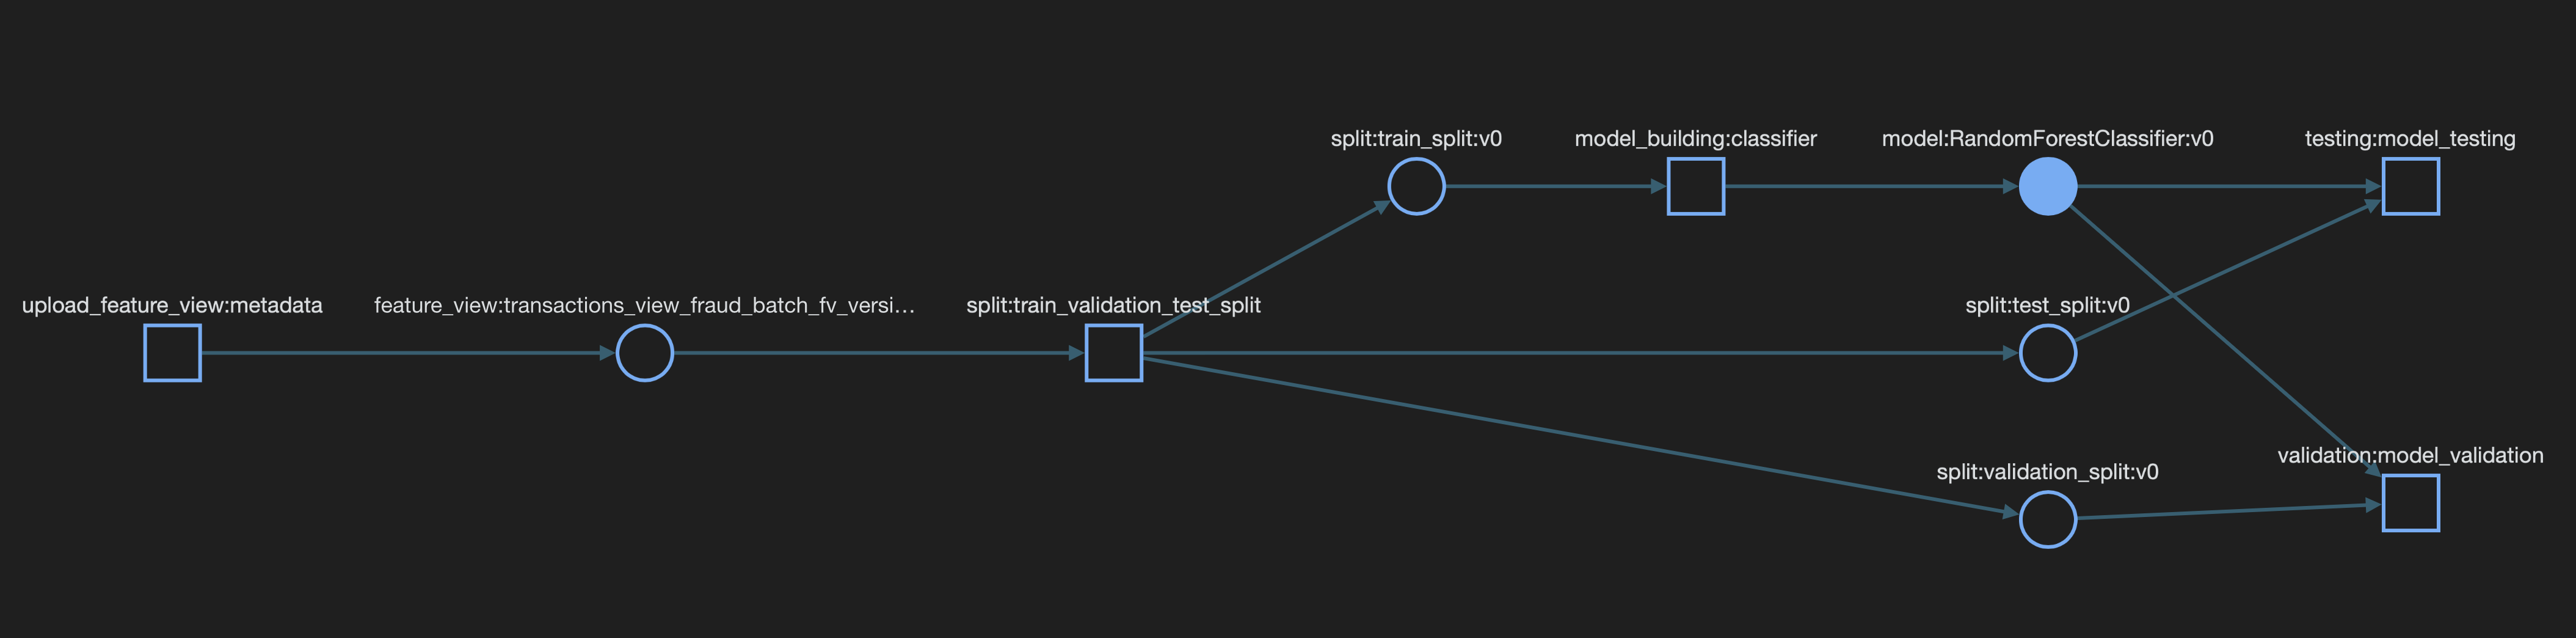

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(y_test, preds))

---
## <span style="color:#ff5f27;">  Use the model to score transactions </span>
We trained model based on January - February data. Now lets retrieve March data and score whether transactions are fraudulend or not   


In [ ]:
from datetime import datetime
date_format = "%Y-%m-%d %H:%M:%S"
# Create training datasets based event time filter
start_time = int(float(datetime.strptime("2022-01-03 00:00:01", date_format).timestamp()) * 1000)
end_time = int(float(datetime.strptime("2022-03-31 23:59:59", date_format).timestamp()) * 1000)

march_transactions = feature_view.get_batch_data(
    start_time = start_time, 
    end_time = end_time
)

In [ ]:
march_transactions

In [ ]:
predictions = clf.predict(march_transactions)

In [ ]:
predictions

---
## <span style="color:#ff5f27;"> 👓  Exploration</span>
In the Hopsworks feature store, the metadata allows for multiple levels of explorations and review. Here we will show a few of those capacities. 

### 🔎 <b>Search</b> 
Using the search function in the ui, you can query any aspect of the feature groups, feature_view and training data that was previously created.

### 📊 <b>Statistics</b> 
We can also enable statistics in one or all the feature groups.

In [ ]:
trans_fg = fs.get_feature_group("transactions_fraud_batch_fg", version = 1)
trans_fg.statistics_config = {
    "enabled": True,
    "histograms": True,
    "correlations": True
}

trans_fg.update_statistics_config()
trans_fg.compute_statistics()

![fg-statistics](../images/fg_statistics.gif)


### ⛓️ <b> Lineage </b> 
In all the feature groups and feature view you can look at the relation between each abstractions; what feature group created which training dataset and that is used in which model.
This allows for a clear undestanding of the pipeline in relation to each element. 

## <span style="color:#ff5f27;"> 🎁  Wrapping things up </span>

We have now performed a simple training with training data that we have created in the feature store. This concludes the fisrt module and introduction to the core aspect of the feauture store. In the second module we will introduce streaming and external feature groups for a similar fraud use case.